## Homework 4

Use this notebook as a starter

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv("E:\Machine Learning\HomeWork4\CreditScoring.csv")
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [9]:
numerical=['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']
categorical=['home','job', 'records' ,'marital']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [12]:
from sklearn.metrics import roc_auc_score
numerical_copy=numerical.copy()
numerical_copy.remove('default')
for feature in numerical_copy:
        print (feature)
        auc=roc_auc_score(df_train['default'],df_train[feature])
        print (auc)
        if auc < 0.5:
            auc=roc_auc_score(df_train['default'],-df_train[feature])
        print (auc)

seniority
0.2906221375508058
0.7093778624491943
time
0.5608662489595051
0.5608662489595051
age
0.4267066727500061
0.5732933272499939
expenses
0.4990815782782989
0.5009184217217011
income
0.31799333386736695
0.682006666132633
assets
0.35139574328771983
0.6486042567122802
debt
0.49521703242164505
0.5047829675783548
amount
0.5910773431595518
0.5910773431595518
price
0.5043329862114843
0.5043329862114843


In [13]:
df_train[numerical].corrwith(df_train.default)
# just making sure that corr is negative for the features above with AUC value below 0.5

seniority   -0.273676
time         0.111368
age         -0.118498
expenses     0.030833
income      -0.233771
assets      -0.116774
debt         0.007422
amount       0.147109
price        0.009518
default      1.000000
dtype: float64

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

#### The highest AUC is Seniority = 0.7

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [17]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
default_decision = (y_pred >= 0.5)
(y_val == default_decision).mean()

0.7800224466891134

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

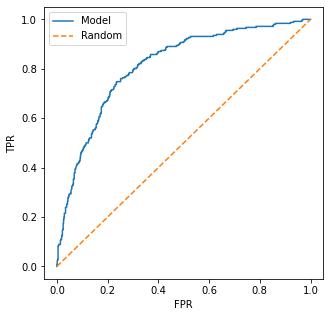

In [20]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [19]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.8120879813449298

#### The AUC of this model on the validation dataset is 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

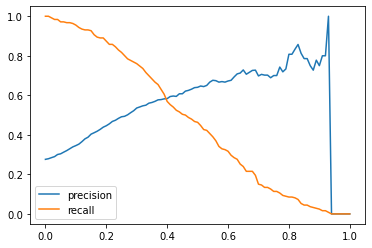

In [51]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

scores=[]
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    default_decision = (y_pred >= t)
    accuracy=(y_val == default_decision).mean()
    
    precision=precision_score(y_val,default_decision)
    recall=recall_score(y_val,default_decision)
    scores.append((t, accuracy, precision, recall))
columns = ['threshold', 'accuracy', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

#### They intersect at threshold 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [53]:
from sklearn.metrics import f1_score
values=[]
for t in thresholds:
    default_decision = (y_pred >= t)
    accuracy=(y_val == default_decision).mean()
    
    precision=precision_score(y_val,default_decision)
    recall=recall_score(y_val,default_decision)
    fscore=f1_score(y_val,default_decision)
    values.append((t, accuracy, precision, recall, fscore))
columns = ['threshold', 'accuracy', 'precision', 'recall', 'fscore']
df_values_new = pd.DataFrame(values, columns=columns)

In [63]:
df_values_new[df_values_new['fscore']==df_values_new.fscore.max()]

,threshold,accuracy,precision,recall,fscore
30,0.3,0.751964,0.535817,0.760163,0.628571


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

#### F1 is max at 0.3 threshold

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [73]:
y_full_train=np.concatenate((y_train, y_val), axis=0)

In [82]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


2850

In [85]:
scores=[]
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values

    df_train = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_full_train = dv.fit_transform(df_train)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_full_train, y_train)

    val_dicts = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
np.std(scores)

0.014611424893554475

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

#### The standard devidation of the scores = 0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [97]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    scores=[]
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        df_train = df_train[features].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_full_train = dv.fit_transform(df_train)

        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_full_train, y_train)

        val_dicts = df_val[features].to_dict(orient='records')
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]
        default_decision = (y_pred >= 0.5)
        mean_score = (y_val == default_decision).mean().round(3)
        auc = roc_auc_score(y_val, y_pred).round(3)
        scores.append(auc)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.814 +- 0.015
C=0.1 0.814 +- 0.015
C=1 0.814 +- 0.015
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

#### All C's leads to the best mean score but C=0.01 is the smallest to make that